In [97]:
from pathlib import Path

import polars as pl
from safetensors.torch import load_file
import seaborn as sns

import torch

In [2]:
basepath = Path("/users/cn/itrujnara/genomes-project/infer_chromosome/one_chunk/tensors")

# 7b_base vs. 7b

In [3]:
probs_base = load_file(basepath / "probs_context8192_stride512.safetensors")["probs"]

In [4]:
probs_base.shape

torch.Size([122880, 4])

In [5]:
probs_long = load_file(basepath / "evo2_7b_probs_context8192_stride512.safetensors")["probs"]

In [6]:
probs_long.shape

torch.Size([122880, 4])

In [7]:
((probs_long - probs_base) ** 2).sum(dim=1).sqrt().mean()

tensor(0.0648)

# Embedding distances

In [105]:
emb_tensors = {}

for stride in [16,32,64,128,256,512]:
    emb_tensors[stride] = load_file(basepath / f"evo2_7b_embeddings_context8192_stride{stride}.safetensors")["embeddings"]

In [9]:
#emb_tensors

## Exploration

In [106]:
((emb_tensors[16] - emb_tensors[512]) ** 2).sum(dim=1).sqrt().mean()

tensor(0.0981)

In [66]:
print(emb_tensors[32].mean())
print(emb_tensors[32].median())
print(emb_tensors[32].min())
print(emb_tensors[32].max())
print(emb_tensors[32].std())

tensor(0.0059)
tensor(-0.0001)
tensor(-4.5312)
tensor(26.2500)
tensor(0.3778)


In [57]:
# ax = sns.histplot(emb_tensors[64][50000,:]).set_xlim(-1,1)

## Null distribution

In [25]:
torch.random.manual_seed(42)

t1 = torch.normal(0.0059, 0.3778, (122880, 4096))
t2 = torch.normal(0.0059, 0.3778, (122880, 4096))

In [26]:
null_dist = ((t1 - t2) ** 2).sum(dim=1).sqrt()

In [28]:
null_dist.mean()

tensor(34.1913)

In [29]:
null_dist.std()

tensor(0.3781)

In [81]:
null_dist.min()

tensor(32.4483)

In [34]:
(null_dist < 0.0162).sum()

tensor(0)

## Permutation

In [82]:
torch.random.manual_seed(42)

idx = torch.randperm(122880)
idx

tensor([15462, 51829, 50938,  ..., 36430, 60069, 49583])

In [107]:
perm_dist = ((emb_tensors[16] - emb_tensors[16][idx,:]) ** 2).sum(dim=1).sqrt()

In [108]:
perm_dist.mean()

tensor(5.0270)

In [109]:
perm_dist.min()

tensor(0.)

## All distances

In [115]:
distances = {}

for stride in emb_tensors:
    distances[str(stride)] = ((emb_tensors[stride] - emb_tensors[16]) ** 2).sum(dim=1).sqrt()

In [116]:
distances["512"].mean()

tensor(0.0981)

In [120]:
for stride in distances:
    print(f"{stride}: {distances[stride].median():.4f}")

16: 0.0000
32: 0.0589
64: 0.0609
128: 0.0632
256: 0.0666
512: 0.0720


In [78]:
((0.09 ** 2) / 4096) ** 0.5

0.00140625

In [80]:
(null_dist < 0.0976).sum()

tensor(0)

In [95]:
(perm_dist < 0.0976).sum()

tensor(1)

In [118]:
df_distances = pl.DataFrame(distances)
df_distances

16,32,64,128,256,512
f32,f32,f32,f32,f32,f32
0.0,0.137791,0.137268,0.137944,0.137099,0.139437
0.0,0.038088,0.029794,0.033354,0.037222,0.042611
0.0,0.035785,0.026591,0.032823,0.026001,0.129137
0.0,0.029713,0.037496,0.039382,0.044721,0.042446
0.0,0.128005,0.019537,0.035085,0.044519,0.044468
…,…,…,…,…,…
0.0,0.037161,0.035963,0.051523,0.027435,0.053804
0.0,0.042167,0.030132,0.14463,0.03868,0.045553
0.0,0.0383,0.034973,0.130475,0.03345,0.033231


<Axes: xlabel='variable', ylabel='value'>

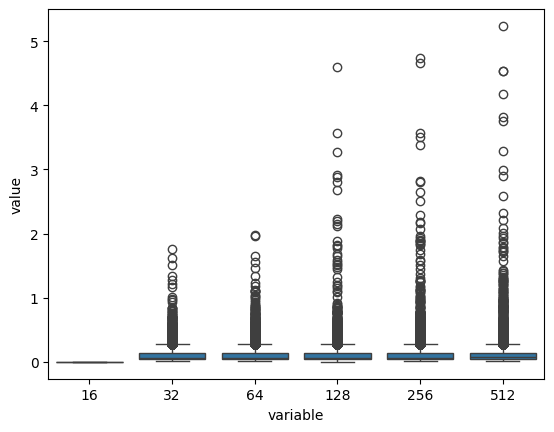

In [119]:
sns.boxplot(df_distances.unpivot(), x="variable", y="value")